# [Implementation and application patterns for explaining methods]()
-------
#### Software chapter of the "Interpretable AI: Interpreting, Explaining and Visualizing Deep Learning" book 
--------

This is the accompanying code for the software chapter of the book "Interpretable AI: Interpreting, Explaining and Visualizing Deep Learning". For a more detailed understanding please have a look into the chapter: [TODO: Add link.]().

-------

## Section 3.4

### Preparations

This script needs the ImageNet 2012 validation set and the bounding box data:

In [1]:
# Path to validation images of Imagenet 2012:                                                                                                                                 
# Each directory should contain one directory "all_classes" with all the images:                                                                                                     
# see https://keras.io/preprocessing/image/#imagedatagenerator-class                                                                                                                 
# function flow_from_directory().                                                                                                                                                    
imagenet_val_dir = "val_set"
# Path to extracted bounding box directory of ImageNet 2012:
imagenet_bbox_dir = "val_bboxes"

Extract the bounding box data into one file:

In [2]:
%%bash -s "$imagenet_bbox_dir"
python create_bboxes.py $1

Files in directory: 50000
Read entries: 50000


Import required packages:

In [3]:
%load_ext autoreload
%autoreload 2

import warnings
warnings.simplefilter('ignore')

In [ ]:
%matplotlib inline  


import matplotlib
import matplotlib.patches

import imp
import json
import keras.backend
import keras.models
import keras.preprocessing.image
import keras.utils
import math
import matplotlib.pyplot as plt
import numpy as np
import sys
import os

import innvestigate
import innvestigate.tools
import innvestigate.utils as iutils
import innvestigate.utils.tests.networks.imagenet
import innvestigate.utils.visualizations as ivis

Using TensorFlow backend.


In [ ]:
base_dir = ".."
meta_data_dir = os.path.join(base_dir, "images")

# Use utility libraries to focus on relevant iNNvestigate routines.
eutils = imp.load_source("utils", "../utils.py")
imgnetutils = imp.load_source("utils_imagenet", "../utils_imagenet.py")

Specify network and build it:

In [ ]:
netname = "vgg16"
batch_size = 24

tmp = getattr(innvestigate.applications.imagenet, netname)
net = tmp(load_weights=True)
model = keras.models.Model(inputs=net["in"], outputs=net["out"])
model.compile(optimizer="adam", loss="categorical_crossentropy")
modelp = keras.models.Model(inputs=net["in"], outputs=net["sm_out"])
modelp.compile(optimizer="adam", loss="categorical_crossentropy",
               metrics=["accuracy"])

Create an analyzer:

In [ ]:
analyzer = innvestigate.create_analyzer(
    "lrp.sequential_preset_a", model, neuron_selection_mode="index")

Create data loaders:

In [ ]:
channels_first = keras.backend.image_data_format() == "channels_first"
color_conversion = "BGRtoRGB" if net["color_coding"] == "BGR" else None

if channels_first:
    target_size = net["input_shape"][2:4]
else:
    target_size = net["input_shape"][1:3]

def preprocess(X):
    X = X.copy()
    X = net["preprocess_f"](X)
    return X
                                                                                                                    
test_data_generator = keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=preprocess)

Load meta-data like bounding boxes and labels:

In [ ]:
# Loading bounding boxes, labels and label_names                                                                                                                                 
with open("imagenet2012_val_bboxes.json") as f:
    bbox_dict = json.load(f)
with open(os.path.join(meta_data_dir, "ground_truth_val2012")) as f:
    ground_truth_val2012 = {x.split()[0]: int(x.split()[1])
                            for x in f.readlines() if len(x.strip()) > 0}
with open(os.path.join(meta_data_dir, "imagenet_label_mapping")) as f:
    label_to_name_mapping = {int(x.split(":")[0]): x.split(":")[1].strip()
                             for x in f.readlines() if len(x.strip()) > 0}

def normalize_bbox(bbox):
    x = bbox["width"], bbox["xmin"], bbox["xmax"]
    y = bbox["height"], bbox["ymin"], bbox["ymax"]
    x_smaller_than_y = x[0] < y[0]

    # Assume x is larger side                                                                                                                                                    
    if x_smaller_than_y:
        x, y = y, x

    assert target_size[0] == target_size[1]
    scale = target_size[0] / x[0]
    # Smaller side is centered.                                                                                                                                                  
    shift = (x[0]-y[0]) * 0.5

    # Scale boxes                                                                                                                                                                
    x_norm = x[1] * scale, x[2] * scale
    y_norm = (y[1]+shift) * scale, (y[2]+shift) * scale

    # Adjust to pixel indices                                                                                                                                                    
    x_norm = int(math.floor(x_norm[0])), int(math.ceil(x_norm[1]))
    y_norm = int(math.floor(y_norm[0])), int(math.ceil(y_norm[1]))

    if x_smaller_than_y:
        x_norm, y_norm = y_norm, x_norm
    return x_norm, y_norm


def meta_data_for_batch(filenames):
    filenames = [os.path.basename(f) for f in filenames]

    labels = [ground_truth_val2012[f] for f in filenames]
    bboxes = [normalize_bbox(bbox_dict[os.path.splitext(f)[0]])
              for f in filenames]

    return labels, bboxes

### Process the data

Evaluate the whole dataset and store the information:

In [ ]:
def create_val_generator():
    # Create actual generator for the validation data folder                                                                                                                     
    generator = test_data_generator.flow_from_directory(
        imagenet_val_dir,
        shuffle=False,  # Has to be False in order to recover filenames!                                                                                                         
        target_size=target_size,
        batch_size=batch_size,
        class_mode=None)
    return generator

filenames = []
true_labels = []
pred_labels = []
bboxes = []
analysis_ratio = []

nr_batches = int(math.ceil(50000 / batch_size))
val_generator = create_val_generator()
for i, batch in enumerate(val_generator):
    if (i+1) % 100 == 0:
        print("%s of %s mb" % (i+1, nr_batches))
    if i >= nr_batches:
        # Generator does not stop itself.
        break

    # Get indices and meta-data
    idx = (val_generator.batch_index - 1) * val_generator.batch_size
    batch_filenames = val_generator.filenames[
        idx:idx + val_generator.batch_size]
    batch_true_labels, batch_bboxes = meta_data_for_batch(batch_filenames)

    # Get prediction and analysis
    batch_pred_labels = modelp.predict_on_batch(batch).argmax(axis=1)
    analysis = analyzer.analyze(batch, neuron_selection=batch_pred_labels)

    # Compute bounding box ratios
    batch_ana_ratio = []
    for bbox, a in zip(batch_bboxes, analysis):
        a = np.abs(a)
        if channels_first:
            inside_bbox = a[:, bbox[0][0]:bbox[0][1],
                            bbox[1][0]:bbox[1][1]].sum()
        else:
            inside_bbox = a[bbox[0][0]:bbox[0][1],
                            bbox[1][0]:bbox[1][1]].sum()
        batch_ana_ratio.append(inside_bbox/a.sum())

    # Store infos
    filenames += batch_filenames
    true_labels += batch_true_labels
    pred_labels.append(batch_pred_labels)
    analysis_ratio += batch_ana_ratio
    bboxes += batch_bboxes


true_labels = np.asarray(true_labels).flatten()
pred_labels = np.concatenate(pred_labels).flatten()
analysis_ratio = np.asarray(analysis_ratio).flatten()


100 of 2084 mb
200 of 2084 mb
300 of 2084 mb
400 of 2084 mb
500 of 2084 mb
600 of 2084 mb
700 of 2084 mb
800 of 2084 mb
900 of 2084 mb
1000 of 2084 mb
1100 of 2084 mb
1200 of 2084 mb
1300 of 2084 mb
1400 of 2084 mb
1500 of 2084 mb
1600 of 2084 mb
1700 of 2084 mb
1800 of 2084 mb
1900 of 2084 mb
2000 of 2084 mb


Lets do some analysis:

In [ ]:
# Cut off last batch's tail.
pred_labels = pred_labels[:len(true_labels)]

print("Accuracy on val set (single crop):", np.mean(true_labels == pred_labels))
print("Inside bbox mean:", np.mean(analysis_ratio.mean()))

analysis_ratio_per_class = []
for i in range(1000):
    if i in true_labels:
        analysis_ratio_per_class.append((np.mean(analysis_ratio[true_labels == i]), i))

acc_per_class = []
for i in range(1000):
    if i in true_labels:
        acc_per_class.append((np.mean(pred_labels[true_labels == i] == i), i))

most_misspred_per_class = []
for i in range(1000):
    if i in true_labels:
        counts = np.bincount(pred_labels[np.logical_and(true_labels == i, pred_labels != i)])
        if len(counts):
            most_misspred_per_class.append((np.max(counts), np.argmax(counts), i))


Accuracy on val set (single crop): 0.6427228356537046
Inside bbox mean: 0.36517477


Convience plotting functions:

In [ ]:
def add_bbox(bbox):
    rect = matplotlib.patches.Rectangle((bbox[0][0],bbox[1][0]),
                                    bbox[0][1]-bbox[0][0], bbox[1][1]-bbox[1][0],
                                    linewidth=0.5, edgecolor='r', facecolor='none')
    plt.gca().add_patch(rect)


def show_image_range(a_range, file_name=None):
    for i in a_range:
        print("True: %s | Pred: %s | Ana-in-bbox-ratio: %s | Index: %s" % (
            label_to_name_mapping[true_labels[i]], label_to_name_mapping[pred_labels[i]], analysis_ratio[i], i))
        x_not_pp = eutils.load_image(os.path.join(imagenet_val_dir, filenames[i]), target_size[0])[None]
        x = preprocess(x_not_pp)
        plt.figure(figsize=(1, 1), dpi=target_size[0])
        plt.imshow(x_not_pp[0]/255, interpolation="nearest")
        add_bbox(bboxes[i])
        plt.axis("off")
        if file_name is not None:
            plt.tight_layout()
            tmp = ".".join(file_name.split(".")[:-1])+("_%i_img." % i)+file_name.split(".")[-1]
            plt.gca().set_axis_off()
            plt.subplots_adjust(top = 1, bottom = 0, right = 1, left = 0, hspace = 0, wspace = 0)
            plt.margins(0,0)
            plt.gca().xaxis.set_major_locator(plt.NullLocator())
            plt.gca().yaxis.set_major_locator(plt.NullLocator())
            plt.savefig(tmp, bbox_inches='tight', pad_inches=0)
        plt.show()

        a = analyzer.analyze(x, neuron_selection=true_labels[i])
        a = imgnetutils.postprocess(a, color_conversion, channels_first)
        plt.figure(figsize=(1, 1), dpi=target_size[0])
        plt.imshow(imgnetutils.heatmap(a)[0], interpolation="nearest")
        add_bbox(bboxes[i])
        plt.axis("off")
        if file_name is not None:
            plt.tight_layout()
            tmp = ".".join(file_name.split(".")[:-1])+("_%i_ana." % i)+file_name.split(".")[-1]
            plt.gca().set_axis_off()
            plt.subplots_adjust(top = 1, bottom = 0, right = 1, left = 0, hspace = 0, wspace = 0)
            plt.margins(0,0)
            plt.gca().xaxis.set_major_locator(plt.NullLocator())
            plt.gca().yaxis.set_major_locator(plt.NullLocator())
            plt.savefig(tmp, bbox_inches='tight', pad_inches=0)
        plt.show()

### Extract class where background is used for prediction:

Class with lowest analysis "energy" inside the bounding boxes:

In [ ]:
print(label_to_name_mapping[min(analysis_ratio_per_class)[1]])

basketball


Basketball is the class with the lowest ratio of "analysis value" inside the bounding boxes
The following are some picked examples that show how VGG16 focuses on the background instead of the a basket BALL.

Examples where basketball was still classified correctly:

True: basketball | Pred: basketball | Ana-in-bbox-ratio: 0.03176792 | Index: 3616


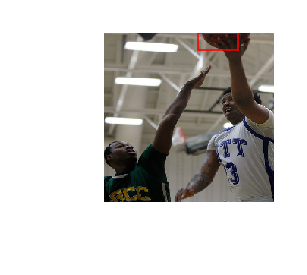

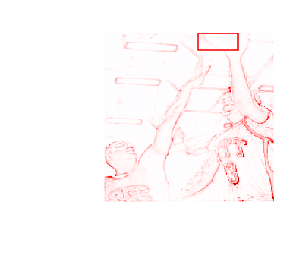

True: basketball | Pred: basketball | Ana-in-bbox-ratio: 0.010420474 | Index: 3673


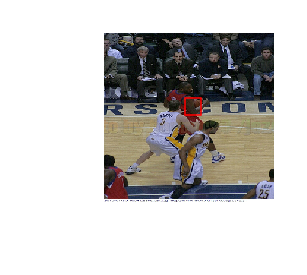

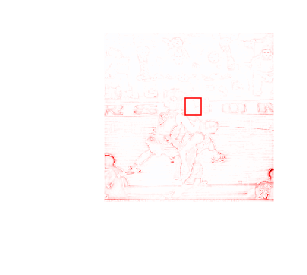

True: basketball | Pred: basketball | Ana-in-bbox-ratio: 0.009348048 | Index: 6098


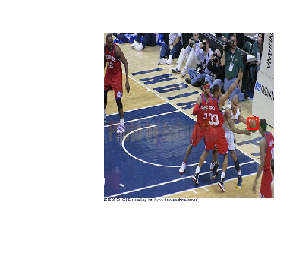

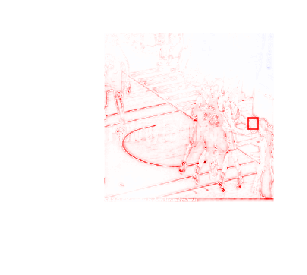

True: basketball | Pred: basketball | Ana-in-bbox-ratio: 0.001757587 | Index: 17292


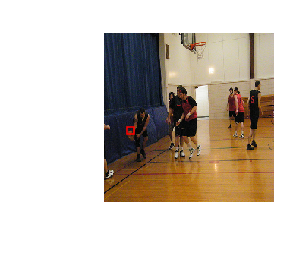

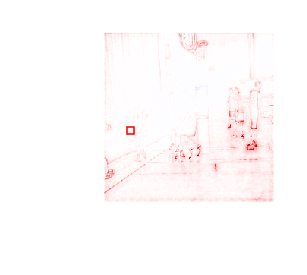

True: basketball | Pred: basketball | Ana-in-bbox-ratio: 0.01699154 | Index: 17396


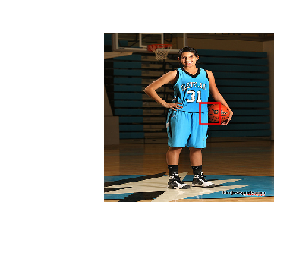

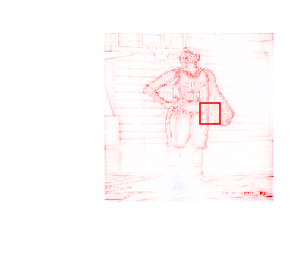

True: basketball | Pred: basketball | Ana-in-bbox-ratio: 0.0018158343 | Index: 31704


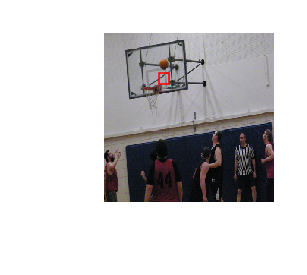

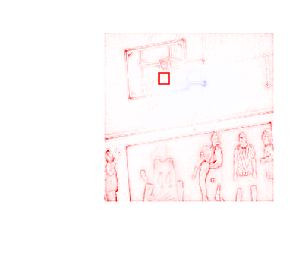

True: basketball | Pred: basketball | Ana-in-bbox-ratio: 0.0038162274 | Index: 31910


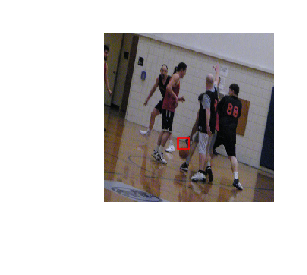

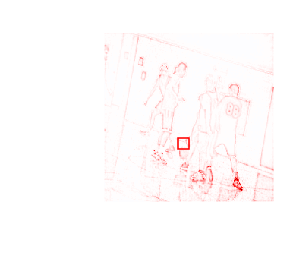

True: basketball | Pred: basketball | Ana-in-bbox-ratio: 0.0050232275 | Index: 32030


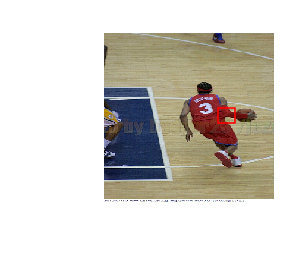

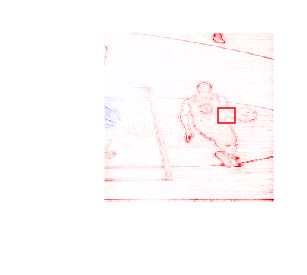

True: basketball | Pred: basketball | Ana-in-bbox-ratio: 0.0006300271 | Index: 34169


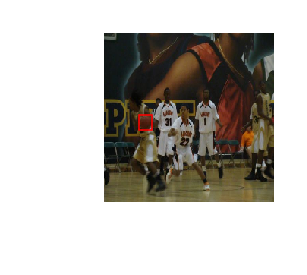

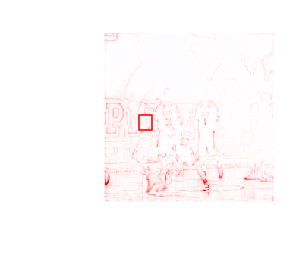

True: basketball | Pred: basketball | Ana-in-bbox-ratio: 0.005481968 | Index: 34472


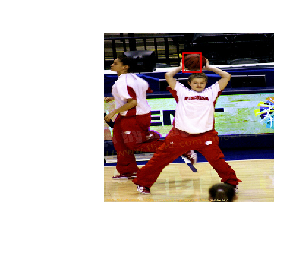

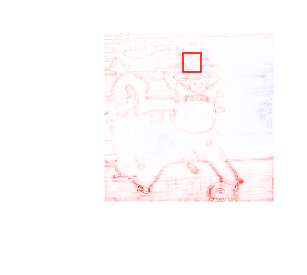

True: basketball | Pred: basketball | Ana-in-bbox-ratio: 0.0021713725 | Index: 35400


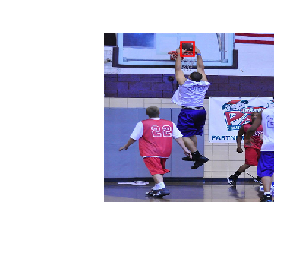

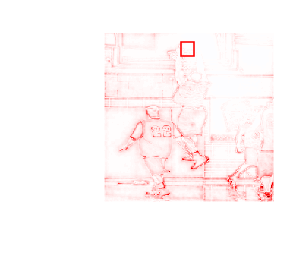

True: basketball | Pred: basketball | Ana-in-bbox-ratio: 0.006160004 | Index: 36608


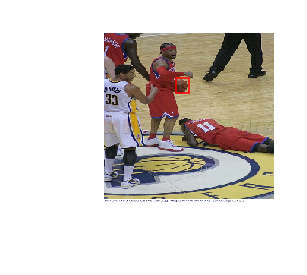

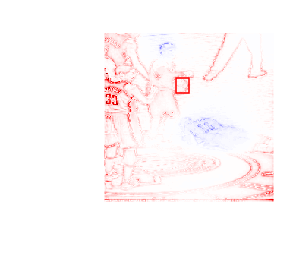

True: basketball | Pred: basketball | Ana-in-bbox-ratio: 0.00014463233 | Index: 38835


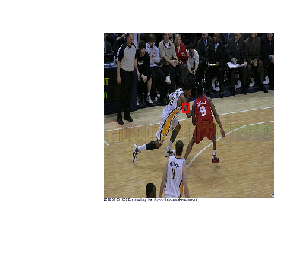

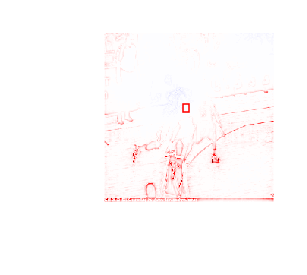

True: basketball | Pred: basketball | Ana-in-bbox-ratio: 0.0020687082 | Index: 42221


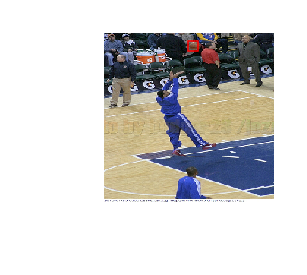

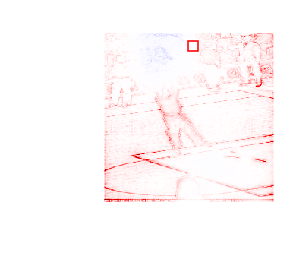

True: basketball | Pred: basketball | Ana-in-bbox-ratio: 0.0067292517 | Index: 49468


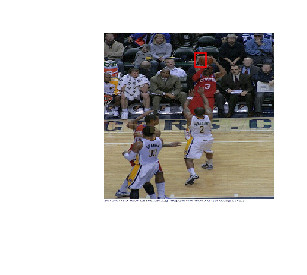

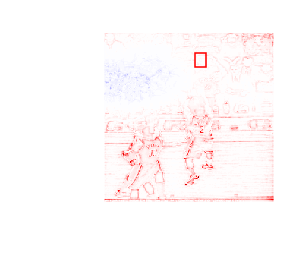

True: basketball | Pred: basketball | Ana-in-bbox-ratio: 0.02432998 | Index: 5181


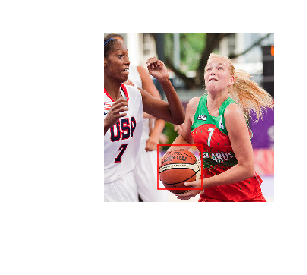

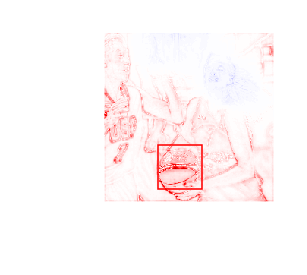

In [ ]:
show_image_range([3616, 3673, 6098, 17292, 17396, 31704, 31910, 32030, 34169, 34472, 35400, 36608, 38835, 42221, 49468, 5181])

Basketball is the class with the lowest ratio of "analysis value" inside the bounding boxes
The following are some picked examples that show how VGG16 focuses on the background instead of the a basket BALL.

Examples where basketball was still classified correctly:

True: basketball | Pred: shoe shop | Ana-in-bbox-ratio: 0.0277548 | Index: 26412


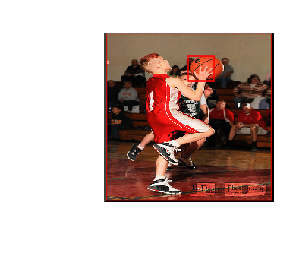

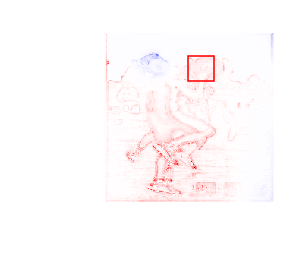

True: basketball | Pred: volleyball | Ana-in-bbox-ratio: 0.0078453375 | Index: 25838


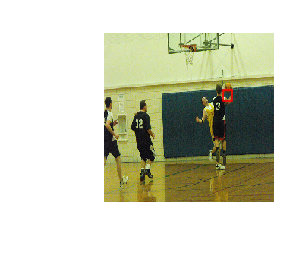

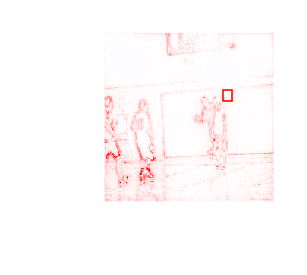

True: basketball | Pred: fur coat | Ana-in-bbox-ratio: 0.0017987125 | Index: 40596


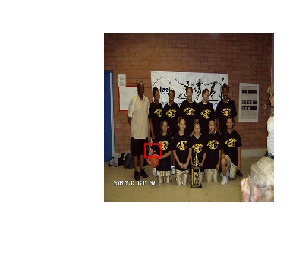

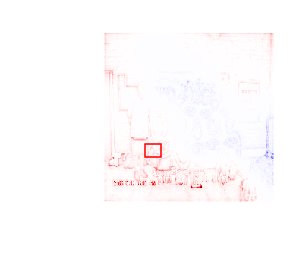

True: basketball | Pred: volleyball | Ana-in-bbox-ratio: 0.014104905 | Index: 2375


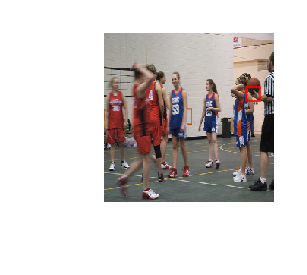

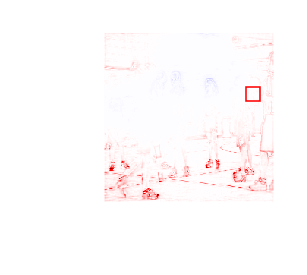

True: basketball | Pred: ping-pong ball | Ana-in-bbox-ratio: 0.05312424 | Index: 9071


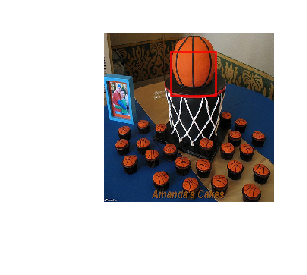

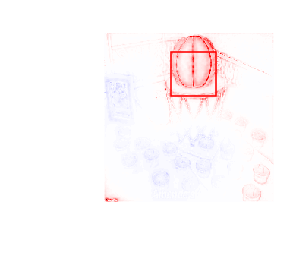

True: basketball | Pred: volleyball | Ana-in-bbox-ratio: 0.0030556587 | Index: 10545


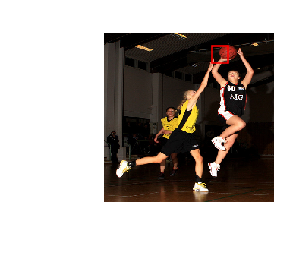

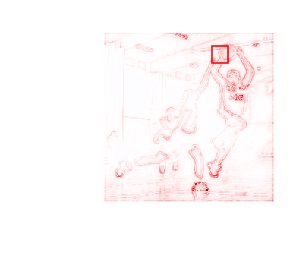

True: basketball | Pred: parachute | Ana-in-bbox-ratio: 0.008644835 | Index: 12395


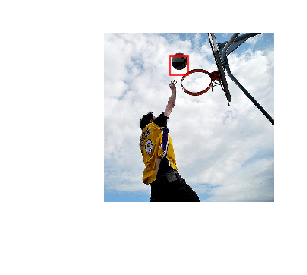

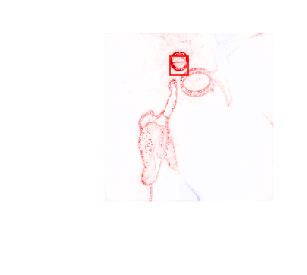

In [ ]:
show_image_range([26412, 25838, 40596, 2375, 9071, 10545, 12395,])

All images for class with lowest ratios:

True: basketball | Pred: basketball | Ana-in-bbox-ratio: 0.00046710938 | Index: 1516


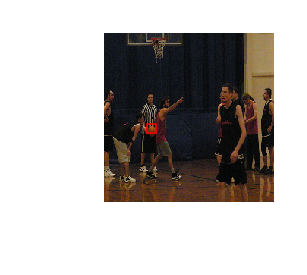

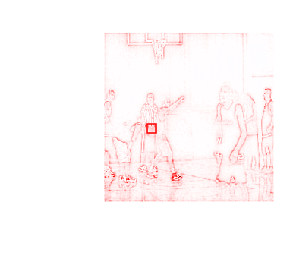

True: basketball | Pred: volleyball | Ana-in-bbox-ratio: 0.014104905 | Index: 2375


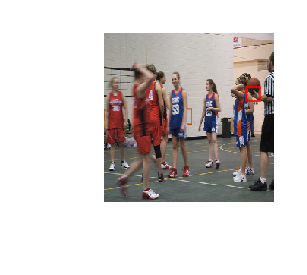

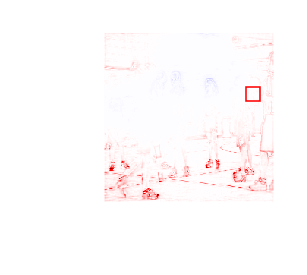

True: basketball | Pred: basketball | Ana-in-bbox-ratio: 0.009108261 | Index: 2537


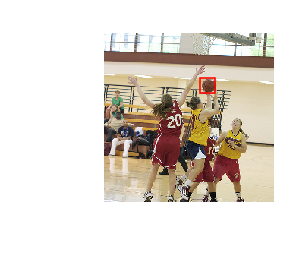

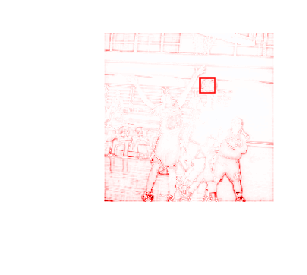

True: basketball | Pred: basketball | Ana-in-bbox-ratio: 0.04561431 | Index: 3036


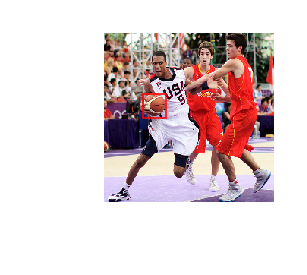

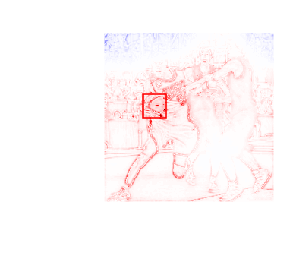

True: basketball | Pred: basketball | Ana-in-bbox-ratio: 0.03176792 | Index: 3616


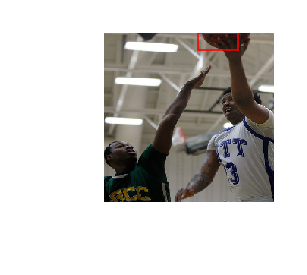

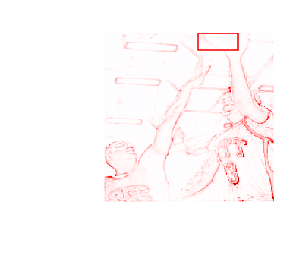

True: basketball | Pred: basketball | Ana-in-bbox-ratio: 0.010420474 | Index: 3673


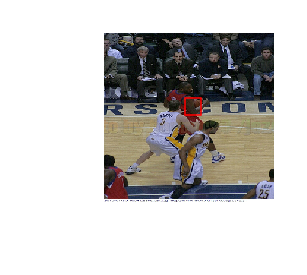

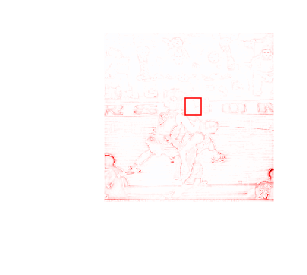

True: basketball | Pred: racket | Ana-in-bbox-ratio: 0.012168855 | Index: 3771


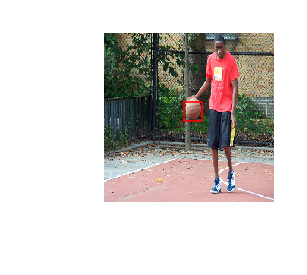

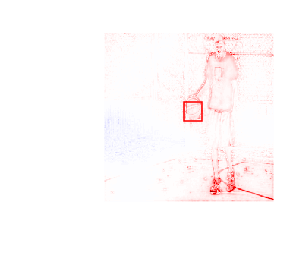

True: basketball | Pred: basketball | Ana-in-bbox-ratio: 0.0025540956 | Index: 4992


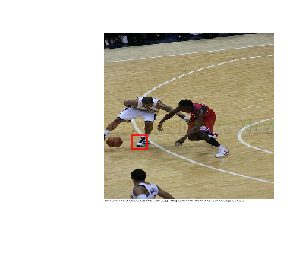

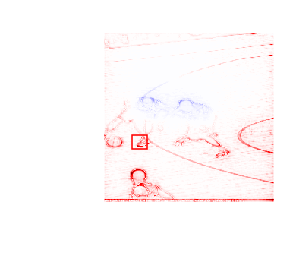

True: basketball | Pred: basketball | Ana-in-bbox-ratio: 0.02432998 | Index: 5181


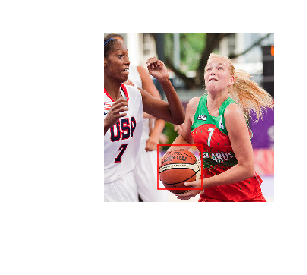

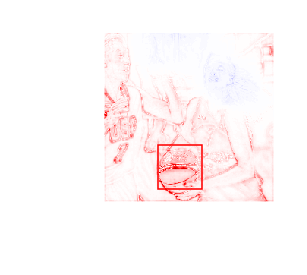

True: basketball | Pred: basketball | Ana-in-bbox-ratio: 0.020350885 | Index: 6080


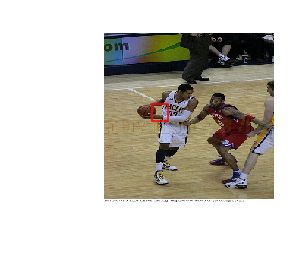

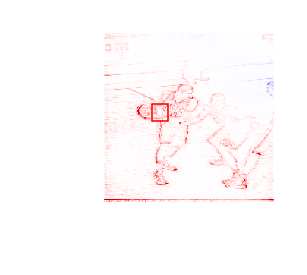

True: basketball | Pred: basketball | Ana-in-bbox-ratio: 0.009348048 | Index: 6098


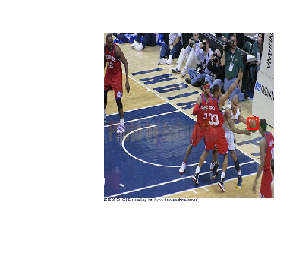

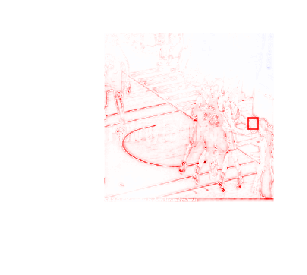

True: basketball | Pred: ping-pong ball | Ana-in-bbox-ratio: 0.05312424 | Index: 9071


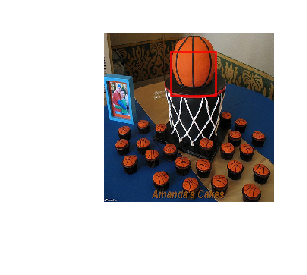

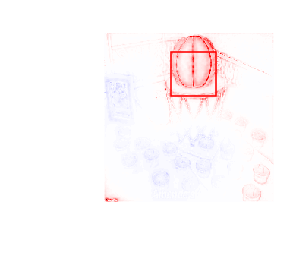

True: basketball | Pred: volleyball | Ana-in-bbox-ratio: 0.0030556587 | Index: 10545


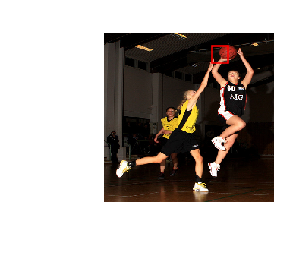

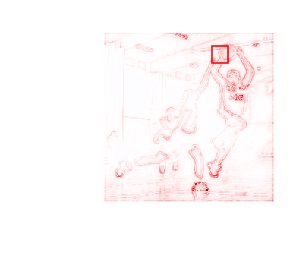

True: basketball | Pred: basketball | Ana-in-bbox-ratio: 0.025456099 | Index: 10908


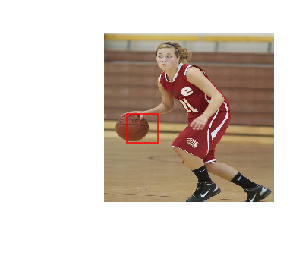

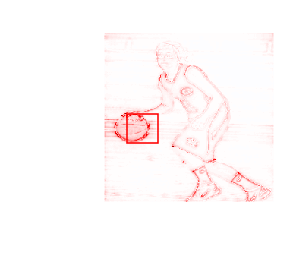

True: basketball | Pred: parachute | Ana-in-bbox-ratio: 0.008644835 | Index: 12395


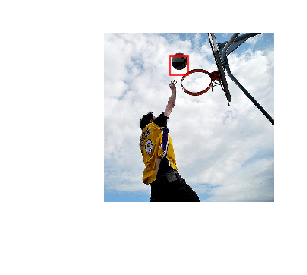

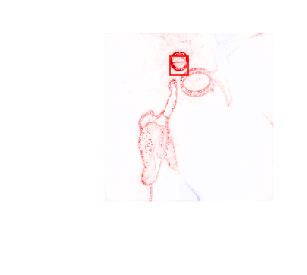

True: basketball | Pred: nail | Ana-in-bbox-ratio: 0.08282308 | Index: 14209


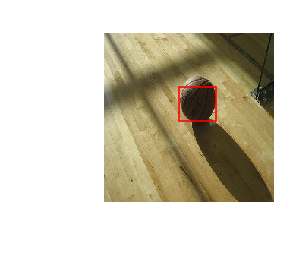

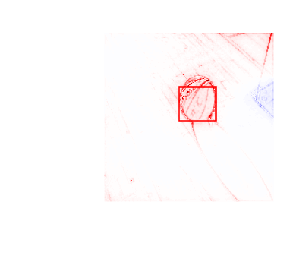

True: basketball | Pred: basketball | Ana-in-bbox-ratio: 0.002302677 | Index: 14381


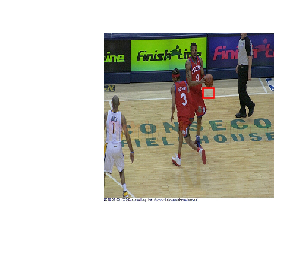

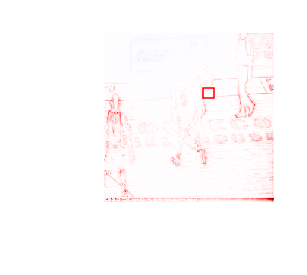

True: basketball | Pred: basketball | Ana-in-bbox-ratio: 0.0022739081 | Index: 15396


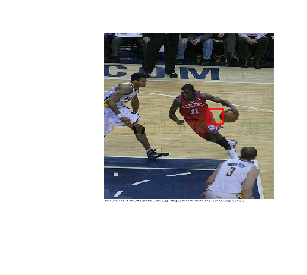

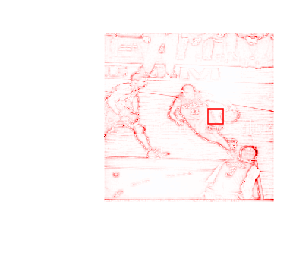

True: basketball | Pred: basketball | Ana-in-bbox-ratio: 0.001757587 | Index: 17292


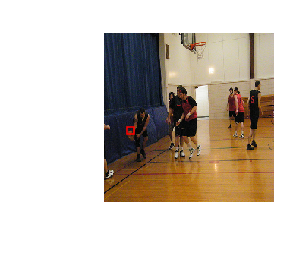

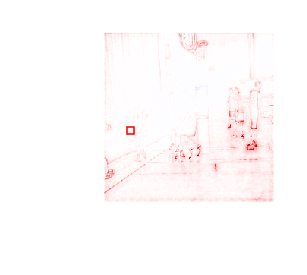

True: basketball | Pred: basketball | Ana-in-bbox-ratio: 0.01699154 | Index: 17396


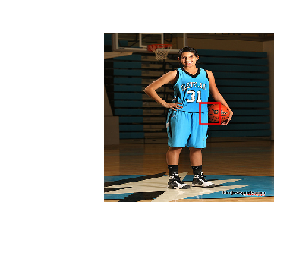

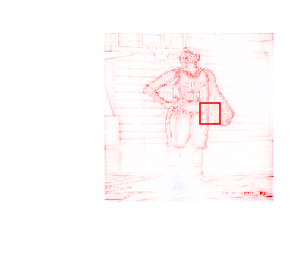

True: basketball | Pred: basketball | Ana-in-bbox-ratio: 0.0042471667 | Index: 18103


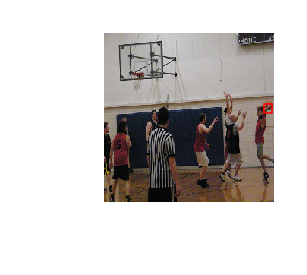

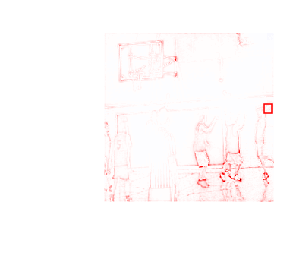

True: basketball | Pred: volleyball | Ana-in-bbox-ratio: 0.0021850318 | Index: 18518


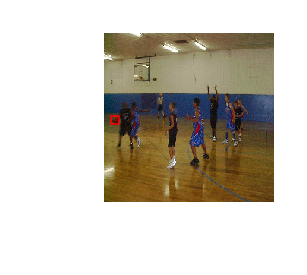

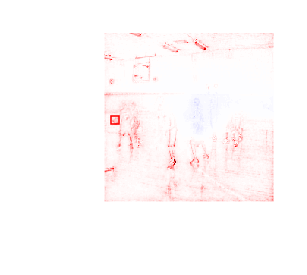

In [ ]:
show_image_range(np.flatnonzero(true_labels == sorted(analysis_ratio_per_class)[0][1])[:])